<a href="https://colab.research.google.com/github/LCaravaggio/politext/blob/main/Toda_la_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar la base

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
base=pd.read_csv('/content/drive/MyDrive/base_formateada.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# CV

In [3]:
base['party'].value_counts()

PSOE    189526
PP      144895
Name: party, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
#base['tokens']=base["tokens"].map(' '.join)
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'party'], base['party'], test_size=0.33, random_state=42)

In [5]:
# Balance de clase
y_train.value_counts()

PSOE    127260
PP       96802
Name: party, dtype: int64

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords=stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Se incorporan las stopwords sugeridas por Federico
stopwords.extend(['señor', 'señora', 'mucha', 'gracia', 'año', 'pasado', 'cada', 'vez', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis' ,'siete', 'ocho', 'nueve', 'diez'])
stopwords.extend(['hoy', 'aquí', 'primer', 'lugar', 'primera', 'segunda', 'primero', 'segundo', 'siguiente', 'tercer'])
stopwords.extend(['convergencia', 'esquerra', 'republicana', 'grupo', 'parlamentaria', 'parlamentario', 'partido'])
stopwords.extend(['enmienda', 'votación', 'favor', 'abstención', 'ley', 'real', 'decreto', 'decretoley', 'resultado', 'voto', 'sé' ,'sí', 'silencio' ,'favor'])
stopwords.extend(['usted', 'señoría', 'presidente', 'presidenta', 'ministro', 'orden' , 'día', 'palabra', 'petición', 'posición', 'punto', 'vista', 'sesión', 'baldoví', 'duran', 'turno'])
stopwords.extend(['hacer', 'frente', 'puede' ,'ser', 'va', 'voy', 'decir'])
stopwords.extend(['millón', 'euro', 'emitido', 'efectuada', 'dio', 'comienzo', 'partido', 'queda', 'quedan', 'rechazada', 'aceptada', 'comienza', 'usted', 'sabe', 'abstención', 'diputado', 'gobierno'])
stopwords.extend(['continuación', 'votamos', 'telemático', 'republicanaizquierda', 'unidainiciativa', 'puede', 'bien', 'propuesta' ,'abstencion', 'mayoría', 'absoluta', 'pregunta', 'don', 'vamos', 'votar', 'llevar', 'cabo', 'millón', 'muchas', 'gracias'])

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=[2,2], max_features=200, stop_words=stopwords, max_df=0.95, min_df=0.001)
vec = cv.fit(X_train['tokens'])

In [9]:
train_matrix = vec.fit_transform(X_train['tokens'])
test_matrix = vec.transform(X_test['tokens'])

# LASSO

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np

In [11]:
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

In [12]:
lr.fit(train_matrix,y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [13]:
predictions = lr.predict(test_matrix)

In [14]:
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[ 8010,  3204],
       [40083, 59062]])

In [15]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          PP       0.17      0.71      0.27     11214
        PSOE       0.95      0.60      0.73     99145

    accuracy                           0.61    110359
   macro avg       0.56      0.65      0.50    110359
weighted avg       0.87      0.61      0.68    110359



In [16]:
# Relevancia de bigramas en la predicción
features=[]
for i,v in enumerate(lr.coef_[0]):
  features.append([vec.get_feature_names_out()[i],v ])

In [17]:
from prettytable import PrettyTable

In [18]:
pd.DataFrame(sorted(features, key = lambda x: x[1]), columns =['Bigrama','relevancia']).head(10)

,Bigrama,relevancia
0,número formula,-4.386114
1,izquierda plural,-2.246694
2,feder izquierda,-2.027500
3,nombr popular,-1.563585
4,portavoz socialista,-1.419491
5,rodríguez zapatero,-1.197709
6,congreso formula,-1.007734
7,interpelación urgent,-0.679360
8,vaya concluyendo,-0.667503
9,diputada doña,-0.645285


In [19]:
pd.DataFrame(sorted(features, key = lambda x: x[1]), columns =['Bigrama','relevancia']).tail(10)

,Bigrama,relevancia
190,reforma labor,0.275013
191,política social,0.281886
192,izquierda per,0.286545
193,económica europea,0.401246
194,nombr socialista,0.420091
195,dictamen comisión,0.801494
196,per catalunya,1.020137
197,coalición popular,1.081059
198,minoría catalana,1.441939
199,catalunya verd,1.593216


In [20]:
# Entiendo que un número negativo en el coeficiente implica que el bigrama correlaciona bien con la clase 0, es decir PP. Por el otro lado, un coeficiente positivo implica que el bigrama correlaciona mejor con PSOE. 
lr.classes_

array(['PP', 'PSOE'], dtype=object)

In [21]:
# LASOO por año
from sklearn.metrics import f1_score

macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

for x in range(1979,2020): 
  try: 
    base_year=base[pd.DatetimeIndex(base.fecha).year==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

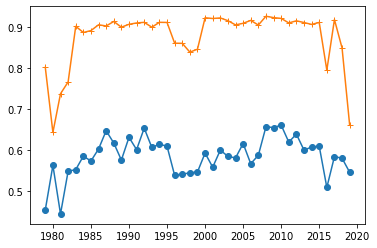

In [22]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(range(1979,2020), macro, marker='o')
plt.plot(range(1979,2020), weighted, marker='+')

In [23]:
# LASOO por legislatura
macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
legislaturas=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII','XIII']

for x in legislaturas: 
  try: 
    base_year=base[base.legislatura==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

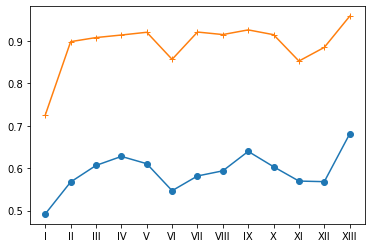

In [24]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(legislaturas, macro, marker='o')
plt.plot(legislaturas, weighted, marker='+')

In [25]:
from tabulate import tabulate

In [26]:
# Relevancia de bigramas en la predicción por año
tabla=[]
for x in range (1979, 2020): 
  base_year=base[pd.DatetimeIndex(base.fecha).year==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = vec.fit_transform(X_train['tokens'])
  test_matrix = vec.transform(X_test['tokens'])
  lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  features=[]
  for i,v in enumerate(lr.coef_[0]):
    features.append([vec.get_feature_names_out()[i],v ])
  sor=sorted(features, key = lambda x: x[1])
  print(f"Año: {x}")
  print(tabulate([sor[:3],sor[-3:]], tablefmt='pretty'))

Año: 1979
+-------------------------------------------+-------------------------------------------+-------------------------------------------+
| ['publicada boletín', -2.401366897519209] |   ['precedido uso', -1.387663345723861]   | ['economía mercado', -1.3691801307275717] |
|  ['sector eléctrico', 1.295984675871848]  | ['formacion política', 1.308957142130175] |  ['director gener', 1.3306086332830904]   |
+-------------------------------------------+-------------------------------------------+-------------------------------------------+
Año: 1980
+--------------------------------------------+---------------------------------------------+-------------------------------------------+
| ['aprobado artículo', -2.8309181682896183] |     ['pérez royo', -2.3056934060662244]     |  ['artículo pausa', -2.0542760425008004]  |
|  ['justicia militar', 1.3937361594331468]  | ['formación profesion', 1.5164589370764923] | ['seguridad jurídica', 1.858318791729696] |
+--------------------------------

In [27]:
# Relevancia de bigramas en la predicción por legislatura
tabla=[]
for x in legislaturas: 
  base_year=base[base.legislatura==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = vec.fit_transform(X_train['tokens'])
  test_matrix = vec.transform(X_test['tokens'])
  lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  features=[]
  for i,v in enumerate(lr.coef_[0]):
    features.append([vec.get_feature_names_out()[i],v ])
  sor=sorted(features, key = lambda x: x[1])
  print(f"Legislatura: {x}")
  print(tabulate([sor[:3],sor[-3:]], tablefmt='pretty'))

Legislatura: I
+---------------------------------------------+--------------------------------------------+--------------------------------------------------+
|     ['ofici cort', -1.407729225797029]      | ['sanidad seguridad', -1.2828416671895149] | ['representant socialista', -1.1084007029099696] |
| ['presupuesto general', 1.3344885018297528] |   ['cualquier caso', 1.593194353400644]    |     ['relacion laboral', 1.8679676653097617]     |
+---------------------------------------------+--------------------------------------------+--------------------------------------------------+
Legislatura: II
+----------------------------------------------+----------------------------------------+-----------------------------------------+
| ['portavoz socialista', -2.0725553848176563] | ['banco derecha', -2.0685258544011957] | ['ninguna manera', -1.4027349241435054] |
|   ['conform dictamen', 3.032463507650641]    | ['artículo pausa', 3.112505621180799]  |  ['número vasco', 3.6043560465597575]  

# LASSO con TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv=TfidfVectorizer(ngram_range=[2,2], max_features=200, stop_words=stopwords, max_df=0.95, min_df=0.01)
vec = cv.fit(X_train['tokens'])

In [29]:
train_matrix = vec.fit_transform(X_train['tokens'])
test_matrix = vec.transform(X_test['tokens'])

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np

In [31]:
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

In [32]:
lr.fit(train_matrix,y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [33]:
predictions = lr.predict(test_matrix)

In [34]:
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[  2,   0],
       [ 24, 389]])

In [35]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          PP       0.08      1.00      0.14         2
        PSOE       1.00      0.94      0.97       413

    accuracy                           0.94       415
   macro avg       0.54      0.97      0.56       415
weighted avg       1.00      0.94      0.97       415



In [36]:
# Relevancia de bigramas en la predicción
features=[]
for i,v in enumerate(lr.coef_[0]):
  features.append([vec.get_feature_names_out()[i],v ])

In [37]:
pd.DataFrame(sorted(features, key = lambda x: x[1]), columns =['Bigrama','relevancia']).head(15)

,Bigrama,relevancia
0,open arm,-2.918464
1,ver si,-2.691838
2,medio comunicación,-2.677379
3,estabilidad presupuestaria,-2.504209
4,cambio climático,-2.471621
5,moción censura,-2.432334
6,tribun constitucion,-2.312757
7,guardia civil,-2.109637
8,diario sesion,-2.007807
9,seguridad social,-1.656107


In [38]:
# Entiendo que un número negativo en el coeficiente implica que el bigrama correlaciona bien con la clase 0, es decir PP. Por el otro lado, un coeficiente positivo implica que el bigrama correlaciona mejor con PSOE. 
lr.classes_

array(['PP', 'PSOE'], dtype=object)

In [39]:
# LASOO por año
from sklearn.metrics import f1_score

macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

for x in range(1979,2020): 
  try: 
    base_year=base[pd.DatetimeIndex(base.fecha).year==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

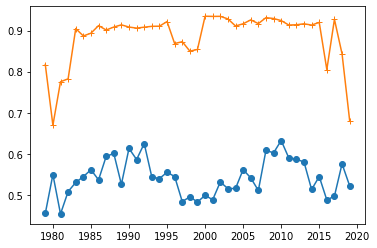

In [40]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(range(1979,2020), macro, marker='o')
plt.plot(range(1979,2020), weighted, marker='+')

In [41]:
# LASOO por legislatura
macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
legislaturas=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII','XIII']

for x in legislaturas: 
  try: 
    base_year=base[base.legislatura==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

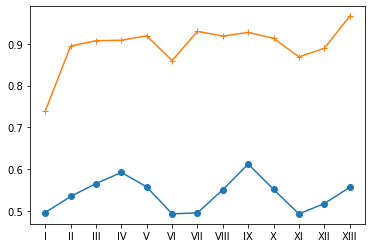

In [42]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(legislaturas, macro, marker='o')
plt.plot(legislaturas, weighted, marker='+')

In [43]:
# Relevancia de bigramas en la predicción por año
for x in range (1979, 2020): 
  base_year=base[pd.DatetimeIndex(base.fecha).year==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = vec.fit_transform(X_train['tokens'])
  test_matrix = vec.transform(X_test['tokens'])
  lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  features=[]
  for i,v in enumerate(lr.coef_[0]):
    features.append([vec.get_feature_names_out()[i],v ])
  sor=sorted(features, key = lambda x: x[1])
  print(f"Año: {x}")
  print(sor[:5])
  print(sor[-5:])

Año: 1979
[['publicada boletín', -4.064106991319182], ['coalición democrática', -2.50663260933744], ['hace falta', -1.2848661679206808], ['precedido uso', -1.2671970183950023], ['economía mercado', -1.2417859635628163]]
[['formacion política', 1.5812018530142713], ['convenio colectivo', 1.6423725313840751], ['comité empresa', 1.655328347878644], ['estatuto trabajador', 1.7373682272529898], ['centro democrático', 1.9119908294120076]]
Año: 1980
[['aprobado artículo', -3.6363028932941073], ['senado artículo', -2.6244902224499675], ['artículo pausa', -2.3778596863487316], ['número socialista', -2.0511024588539106], ['figura dictamen', -1.583326427400662]]
[['artículo dice', 2.2646909339906895], ['director gener', 2.4215102601281546], ['formación profesion', 2.506676865910815], ['tan sólo', 2.747733828142139], ['justicia militar', 3.2731896866487125]]
Año: 1981
[['impuesto renta', -1.9055769608368018], ['coalición democrática', -1.396796679044617], ['frail poujad', -1.247159548753126], ['re

# Regresión lineal

In [44]:
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'party'], base['party'], test_size=0.33, random_state=42)

In [45]:
vec = cv.fit(X_train['tokens'])

In [46]:
train_matrix = vec.fit_transform(X_train['tokens'])
test_matrix = vec.transform(X_test['tokens'])

In [47]:
y_train.replace(['PSOE', 'PP'],[1, -1], inplace=True)
y_test.replace(['PSOE', 'PP'],[1, -1], inplace=True)

In [48]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [49]:
lr.fit(train_matrix,y_train)

LinearRegression()

In [50]:
predictions = lr.predict(test_matrix)

In [51]:
print(lr.coef_)

[-0.33804904 -0.05274399  0.02903043 -0.27104501 -0.05208874  0.50486513
 -1.16025729  0.10455079 -0.19398949 -0.20063203 -0.08980568 -0.04867194
  0.73896995  0.15294982  0.81528503 -0.23139942 -0.16551829 -0.23952042
  0.08024699 -0.03632334  0.0369103  -0.29147099  0.34662239 -0.15986918
 -0.11727466 -0.03426999 -0.20430329]


In [52]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [53]:
regression_results(y_test,predictions)

explained_variance:  0.0278
r2:  0.0277
MAE:  0.9544
MSE:  0.9562
RMSE:  0.9779


In [54]:
# Relevancia de bigramas en la predicción
features=[]
for i,v in enumerate(lr.coef_):
  features.append([vec.get_feature_names_out()[i],v ])

In [55]:
sorted(features, key = lambda x: x[1])

[['feder izquierda', -1.160257293302511],
 ['administracion pública', -0.3380490359212398],
 ['sociedad española', -0.291470992122777],
 ['convergència unió', -0.27104500594604847],
 ['puesto trabajo', -0.23952042054360018],
 ['política económica', -0.23139942075040412],
 ['unión europea', -0.20430328833340825],
 ['medio ambient', -0.20063202982127845],
 ['izquierda unida', -0.19398948883078493],
 ['presupuesto general', -0.16551829349519845],
 ['tan important', -0.15986917985315252],
 ['toma consideración', -0.11727466010774378],
 ['medio comunicación', -0.08980568158262175],
 ['artículo constitución', -0.05274398664920319],
 ['cualquier caso', -0.052088738785977466],
 ['millon peseta', -0.048671940709840184],
 ['seguridad social', -0.03632333780045771],
 ['tribun constitucion', -0.034269992439611464],
 ['comunidad autónoma', 0.029030428016970627],
 ['servicio público', 0.03691029880686206],
 ['ruego concluya', 0.08024698790516914],
 ['izquierda per', 0.10455079288520995],
 ['mismo ti

# LDA

In [56]:
from sklearn.decomposition import LatentDirichletAllocation

In [57]:
vec = cv.fit(base['tokens'])

In [58]:
matrix = vec.transform(base['tokens'])

In [59]:
lda = LatentDirichletAllocation(n_components=40, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

In [60]:
lda.fit(matrix)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=40, random_state=0)

In [61]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(" , ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [62]:
display_topics(lda, feature_names=cv.get_feature_names_out(), no_top_words=20)

Topic 1:
medio comunicación , convergència unió , puesto trabajo , ss ss , seguridad social , artículo constitución , millon peseta , sociedad española , mismo tiempo , política económica , presupuesto general , tan important , administracion pública , per catalunya , medio ambient , izquierda unida , izquierda per , feder izquierda , cualquier caso , servicio público
Topic 2:
convergència unió , unión europea , minoría catalana , artículo constitución , comunidad autónoma , cualquier caso , dictamen comisión , feder izquierda , izquierda per , izquierda unida , medio ambient , medio comunicación , millon peseta , mismo tiempo , tribun constitucion , per catalunya , política económica , presupuesto general , puesto trabajo , ruego concluya
Topic 3:
toma consideración , convergència unió , tan important , artículo constitución , sociedad española , seguridad social , feder izquierda , per catalunya , tribun constitucion , izquierda per , izquierda unida , unión europea , medio ambient ,

In [63]:
# LDA genera una matríz en la que asigna a cada uno de los 200 bigramas una probabilidad de ocurrencia para cada uno de los 40 topics
lda.components_.shape

(40, 27)

# Número óptimo de clusters

In [64]:
# LDA en Sklearn tiene un resultado de score correspondiente al log-likelihood. En base a ese criterio se identifica el número óptimo de clusters. 

from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [5, 10, 20, 40, 60, 80]}

model = LatentDirichletAllocation(n_components=40, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
gridsearch.fit(matrix)

## Save the best model
best_lda = gridsearch.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [65]:
cv_results_df = pd.DataFrame(gridsearch.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,141.960739,1.065958,8.516669,0.248591,5,{'n_components': 5},-94241.834431,-77025.196843,-8.199954e+04,-55871.795723,-50286.477349,-71884.968967,16440.635575,1
1,148.094847,4.273811,8.639051,0.060640,10,{'n_components': 10},-96975.392873,-80192.487786,-8.565397e+04,-61764.509765,-55994.067933,-76116.085766,15189.222011,2
2,154.504221,2.315521,9.271271,0.221929,20,{'n_components': 20},-100077.719126,-89539.243545,-9.692765e+04,-71240.336741,-62239.141923,-84004.818118,14782.721138,3
3,170.500937,1.366142,9.250748,0.150197,40,{'n_components': 40},-101868.061441,-449330.769811,-5.899491e+05,-338971.603909,-161430.587995,-328310.023122,180188.457407,4
4,184.711037,1.786021,9.782034,0.174319,60,{'n_components': 60},-115581.844752,-637916.593233,-8.482195e+05,-482048.451629,-215911.766925,-459935.634393,268722.068688,5
5,189.327042,10.173789,9.201641,1.879018,80,{'n_components': 80},-130667.011874,-825427.142328,-1.108293e+06,-624683.849717,-273364.698928,-592487.095358,356782.871771,6


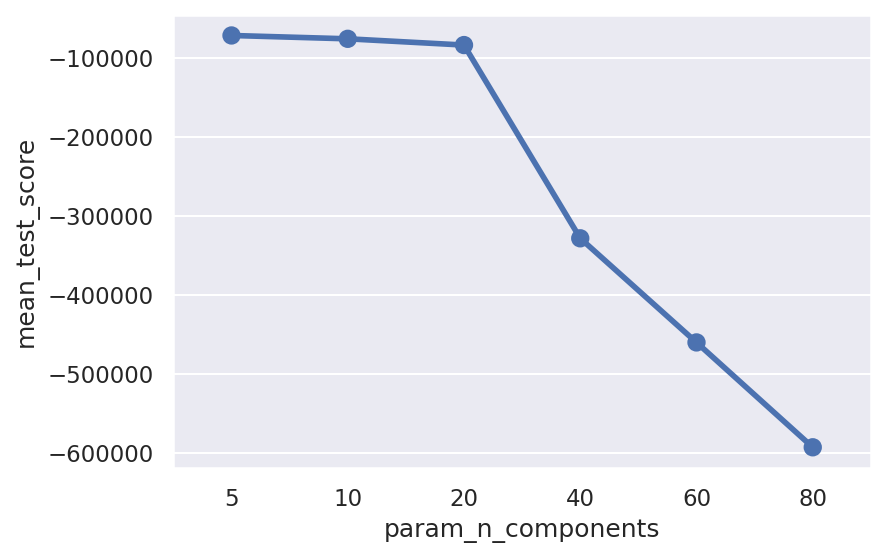

In [66]:
import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components",
              y="mean_test_score",
              data=cv_results_df)

In [67]:
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [10, 13, 16, 20, 25]}

model = LatentDirichletAllocation(n_components=40, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
gridsearch.fit(matrix)

## Save the best model
best_lda = gridsearch.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [68]:
cv_results_df = pd.DataFrame(gridsearch.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,147.897459,2.811619,8.603672,0.052433,10,{'n_components': 10},-96975.392873,-80192.487786,-85653.970472,-61764.509765,-55994.067933,-76116.085766,15189.222011,1
1,150.577996,3.062748,8.621708,0.087660,13,{'n_components': 13},-94949.715504,-83365.247809,-88952.075262,-63521.550207,-56896.957888,-77537.109334,14764.276130,2
2,150.646254,1.342274,8.758973,0.105409,16,{'n_components': 16},-98689.806682,-86836.703394,-92976.984824,-66144.112871,-58583.227359,-80646.167026,15575.799315,3
3,155.597035,0.846981,9.491533,0.547302,20,{'n_components': 20},-100077.719126,-89539.243545,-96927.649253,-71240.336741,-62239.141923,-84004.818118,14782.721138,4
4,144.733050,28.800269,8.175874,1.838230,25,{'n_components': 25},-92357.172904,-96157.019598,-101160.850086,-71430.092307,-63501.501568,-84921.327293,14738.229457,5


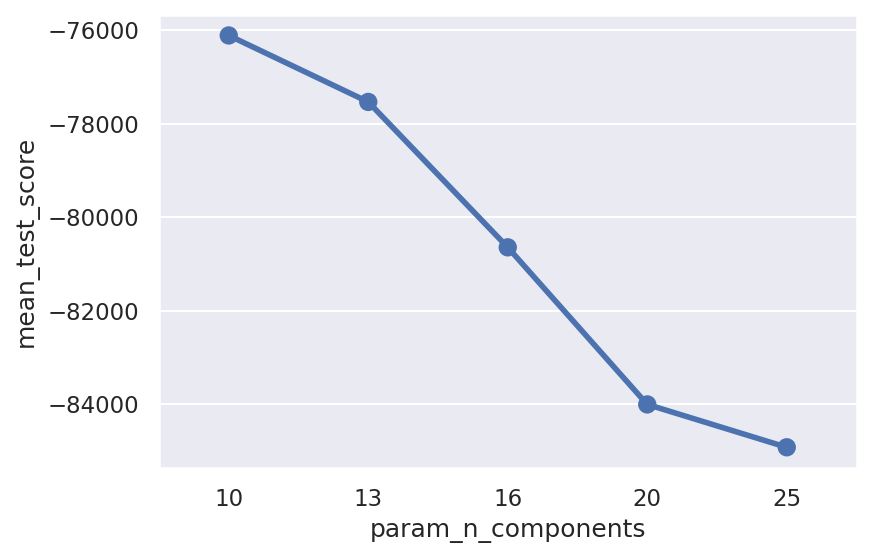

In [69]:
import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components",
              y="mean_test_score",
              data=cv_results_df)

In [82]:
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [8, 10, 12, 14]}

model = LatentDirichletAllocation(n_components=40, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
gridsearch.fit(matrix)

## Save the best model
best_lda = gridsearch.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [83]:
cv_results_df = pd.DataFrame(gridsearch.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,177.284524,0.933983,9.810323,0.084888,8,{'n_components': 8},-808736.599790,-770230.689095,-748109.471359,-647906.270758,-656383.795094,-726273.365219,63616.350754,3
1,177.220908,2.058345,10.947987,1.278167,10,{'n_components': 10},-796149.559412,-763472.794801,-740365.878543,-648269.643174,-656509.586891,-720953.492564,58779.484860,1
2,175.253087,1.646288,9.671688,0.116074,12,{'n_components': 12},-801635.673110,-773731.826256,-752625.456545,-652100.762146,-662968.351374,-728612.413886,60179.663963,4
3,175.330359,1.688152,9.419399,0.536440,14,{'n_components': 14},-791987.349663,-770805.421164,-748065.873647,-652802.600038,-660380.195376,-724808.287978,57455.158330,2


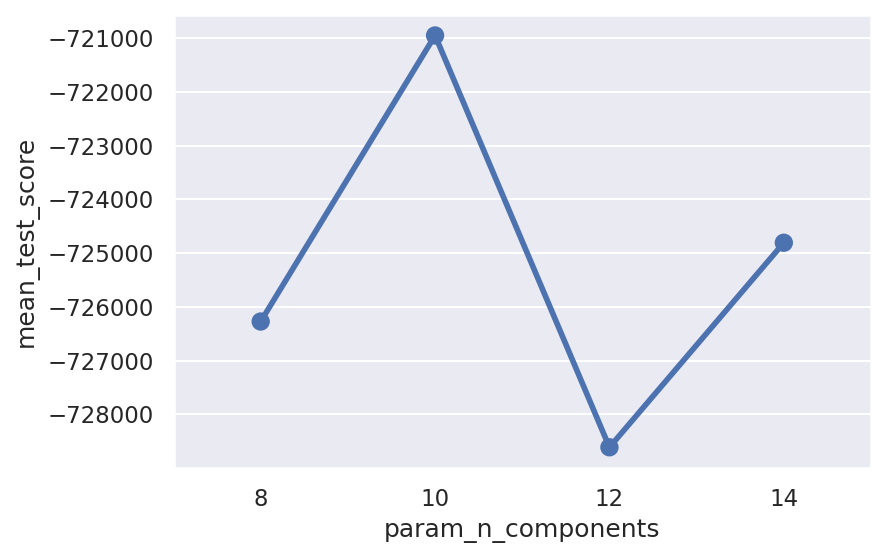

In [84]:
import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components",
              y="mean_test_score",
              data=cv_results_df)

# NNMF

In [73]:
from sklearn.decomposition import NMF

In [74]:
nmf = NMF(n_components=40, random_state=1).fit(matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [75]:
display_topics(nmf, feature_names=cv.get_feature_names_out(),  no_top_words=20)

Topic 1:
dictamen comisión , artículo constitución , cualquier caso , presupuesto general , convergència unió , unión europea , minoría catalana , comunidad autónoma , feder izquierda , izquierda per , izquierda unida , medio ambient , medio comunicación , millon peseta , mismo tiempo , tribun constitucion , per catalunya , política económica , puesto trabajo , ruego concluya
Topic 2:
presupuesto general , seguridad social , millon peseta , unión europea , artículo constitución , comunidad autónoma , convergència unió , cualquier caso , dictamen comisión , feder izquierda , izquierda per , izquierda unida , medio ambient , medio comunicación , mismo tiempo , minoría catalana , tribun constitucion , per catalunya , política económica , puesto trabajo
Topic 3:
per catalunya , izquierda per , servicio público , cualquier caso , unión europea , millon peseta , artículo constitución , comunidad autónoma , convergència unió , dictamen comisión , feder izquierda , izquierda unida , medio ambi

# LDA con 10 clusters

In [76]:
from sklearn.decomposition import LatentDirichletAllocation

In [77]:
cv=CountVectorizer(ngram_range=[2,2], max_features=200, stop_words=stopwords, max_df=0.95, min_df=0.001)
vec = cv.fit(base['tokens'])

In [78]:
matrix = vec.transform(base['tokens'])

In [85]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

In [86]:
lda.fit(matrix)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [87]:
display_topics(lda, feature_names=cv.get_feature_names_out(), no_top_words=20)

Topic 1:
poder judici , violencia género , disposición adicion , asunto exterior , consejo gener , gener poder , comisión europea , administración justicia , cort general , consecuencia interpelación , tribun cuenta , ministerio justicia , moción consecuencia , nombr socialista , entrada vigor , tribun supremo , hace referencia , derecho humano , llegar acuerdo , pueblo español
Topic 2:
popular congreso , interé gener , si quier , exposición motivo , ver si , proyecto orgánica , crédito extraordinario , alguna manera , desean fijar , coalición popular , proposición popular , llegar acuerdo , ahora mismo , si así , aquel momento , hace falta , diputación permanent , hace tiempo , dar respuesta , carácter gener
Topic 3:
izquierda unida , per catalunya , sánchez llibr , rodríguez zapatero , izquierda per , parlamento europeo , portavoz socialista , comisión nacion , proposición popular , feder izquierda , nombr popular , número formula , defensor pueblo , vaya concluyendo , obra pública ,

In [91]:
lda.components_.shape

(10, 200)

In [103]:
import scipy as sp
from scipy.special import logsumexp

In [99]:
def frex(mod, w=0.7):
    log_beta = np.log(mod.components_)
    log_exclusivity = log_beta - logsumexp(log_beta, axis=0)
    exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
    freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
    out = 1. / (w / exclusivity_ecdf + (1 - w) / freq_ecdf)
    return out

In [101]:
def ecdf(arr):
    return sp.stats.rankdata(arr, method='max') / arr.size

In [112]:
frex_df=pd.DataFrame(frex(lda))
frex_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.303927,0.028060,0.310219,0.338462,0.968495,0.676271,0.519675,0.503384,0.589808,0.370462,...,0.048780,0.953494,0.925000,0.014164,0.234123,0.032411,0.478548,0.995000,0.800441,0.728307
1,0.359577,0.028080,0.535135,0.378515,0.290769,0.637798,0.544355,0.548088,0.965000,0.489362,...,0.048148,0.506148,0.392086,0.014177,0.201770,0.032472,0.980000,0.156759,0.846081,0.768385
2,0.344758,0.028172,0.716087,0.364225,0.445254,0.623881,0.597099,0.532639,0.653846,0.416558,...,0.046053,0.325000,0.354822,0.014191,0.273481,0.935000,0.531387,0.144503,0.790419,0.744828
3,0.423007,0.014148,0.611444,0.731493,0.280761,0.498159,0.938910,0.841494,0.498750,0.349367,...,0.034463,0.477823,0.253755,0.007119,0.978495,0.047445,0.453760,0.133106,0.876976,0.808895
4,0.894448,1.000000,0.901977,0.314251,0.454397,0.906977,0.548845,0.489796,0.539073,0.378796,...,0.020921,0.455414,0.240876,0.007119,0.153654,0.032294,0.442579,0.117000,0.685391,0.587379
5,0.310797,0.021098,0.534483,0.325724,0.327273,0.551266,0.569037,0.912977,0.670025,0.369828,...,0.041202,0.309783,0.329032,1.000000,0.166250,0.047756,0.477302,0.145695,0.853901,0.675803
6,0.345468,0.027957,0.462185,0.355450,0.427770,0.744267,0.432787,0.517986,0.570954,0.321389,...,0.048558,0.614484,0.404832,0.014134,0.334241,0.032438,0.490385,0.154839,0.844393,0.778216
7,0.311853,0.021183,0.657825,0.924449,0.450234,0.646557,0.538816,0.473808,0.672913,0.365817,...,1.000000,0.352235,0.926494,0.007116,0.293023,0.047840,0.473939,0.148069,0.762973,0.679505
8,0.834444,0.028112,0.570677,0.799441,0.328421,0.541948,0.534062,0.394030,0.539773,0.918908,...,0.046512,0.417308,0.261980,0.014188,0.101538,0.062233,0.405053,0.107667,0.608195,0.850000
9,0.356250,0.028137,0.759019,0.371467,0.352764,0.604878,0.730769,0.536830,0.555556,0.516070,...,0.048125,0.491052,0.345000,0.014203,0.319695,0.016444,0.507317,0.135491,0.858783,0.756000
